In [ ]:
from sklearn.datasets import load_iris
import numpy as np
  
# Load the dataset
iris = load_iris()
X = iris['data']  # shape: (150, 4)
y = iris['target']

# Standardize features to [0.001, 0.999]
X_min = X.min(axis=0)
X_max = X.max(axis=0)

X_std = (X - X_min) / (X_max - X_min)  # Scales to [0, 1]
X_scaled = X_std * (0.999 - 0.001) + 0.001  # Scales to [0.001, 0.999]

# Check one sample
sample_index = 0
print("Original:", X[sample_index])
print("Standardized:", X_scaled[sample_index])


Original: [5.1 3.5 1.4 0.2]
Standardized: [0.22277778 0.62475    0.06866102 0.04258333]


In [10]:
index = 149
input_sample = X[index]     # shape: (4,) — 4 input features
output_label = y[index]     # scalar class label: 0, 1, or 2

print("Input sample:", input_sample)
print("Target class:", output_label)


for i in range(len(X)):
    inputs = X[i]
    label = y[i]
    # use inputs and label as needed



Input sample: [5.9 3.  5.1 1.8]
Target class: 2


In [40]:
weights = [.5]*2
sp_1 = 0.0
sp_2 = 0.0
sp_3 = 0.0
last_spike = 0.0

print(weights)


[0.5, 0.5]


WARNING    'i' is an internal variable of group 'synapses_30', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]


previous weights:  [0.867420000000003, -0.36922000000000144]


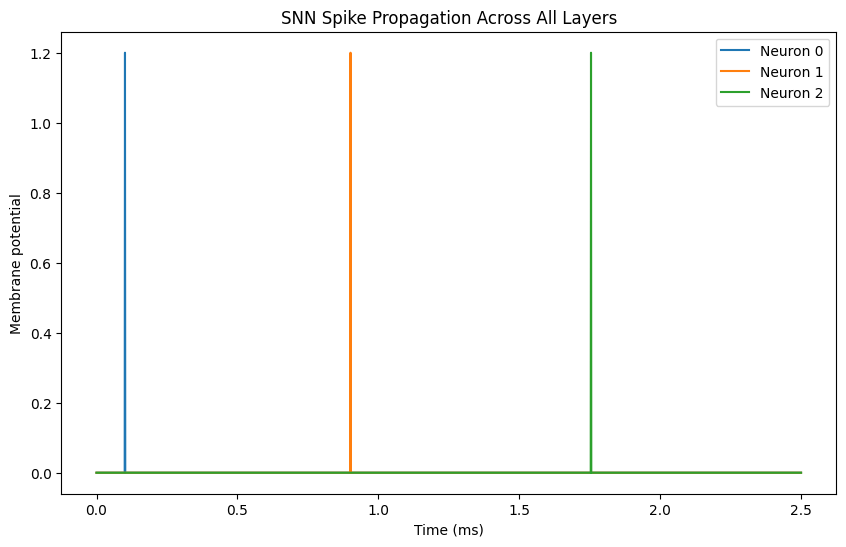

0
Neuron 0 spike times: ['0.101 ms']
1
Neuron 1 spike times: ['0.901 ms']
2
Neuron 2 spike times: ['1.754 ms']
[1.754]


In [107]:
from brian2 import *
import numpy as np

start_scope()

defaultclock.dt = 0.0001*ms  

# Custom timing function
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1, sum=1, spikes_received=1)
def spike_timing(w, global_clock, layer, sum, spikes_received): 
    #print(global_clock)
    x = global_clock % 1
    if w >= 0:
        return (x ** (1 - w)) 
    else:
        return (1 - (1 - x) ** (1 + w)) 
    
@implementation('numpy', discard_units=True)
@check_units(layer=1, result=1, sum=1, spikes_received=1)
def math1(layer, sum, spikes_received): 
    return (sum/spikes_received )+ layer

input = [0.1, 0.9]
n_input = 2 
n_output = 1
n_total = n_input + n_output

# Full neuron group
neurons = NeuronGroup(n_total, '''
    v : 1
    sum : 1
    spikes_received : 1
    scheduled_time : second
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')

neurons.v = 0
neurons.scheduled_time = 1e9 * second
neurons.global_clock = 0.0
neurons.sum = 0.0
neurons.spikes_received = 0.0

# Spike inputs (one per input neuron)     times=[i*0.4 for i in range(n_input)]
stim = SpikeGeneratorGroup(n_input, indices=[0, 1], times=[0.1*ms, 0.9*ms])


# Input → Hidden connections
syn_input = Synapses(stim, neurons[0:2], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
''')
syn_input.connect(j='i') 


syn_output = Synapses(neurons[0:2], neurons[2], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
   
''')
syn_output.connect()

syn_output.w =  weights # np.random.uniform(-0.90, .90, size=1) # [ 0.7116071 , -1.1385437 , -1.088651, 0.43341887, -1.4892002 , -1.3539809 ,0.28178445,  0.152175  , -0.54456943, -1.5054257 ,  0.12284008,  0.49124786, -0.41317764,  0.5724888 ,  0.4868003, 0.38319886,  0.31672755,  0.5698485, -0.7893439 , -0.4332046 ,  1.1470755, -0.619324  , -0.6091148 , -0.2407385, -0.02582   , -0.17720485,  0.3123896, -0.01638766,  0.39673412, -0.4153284 ]
#np.random.uniform(0.10, .90, size=30)
print("previous weights: ", weights)
syn_output.layer = 1

# Scheduled activation & clock update
neurons.run_regularly('''
    v = int(abs(t - scheduled_time) < 0.0005*ms) * 1.2
                      
    global_clock += 0.001
''', dt=0.001*ms)

# Monitors
mon = StateMonitor(neurons, 'v', record=True, dt=0.001*ms)
mon_sum = StateMonitor(neurons, 'sum', record=True)
sp_mon = StateMonitor(neurons, 'spikes_received', record=True)
sch_time = StateMonitor(neurons, 'scheduled_time', record=True)


spikemon = SpikeMonitor(neurons)
spikemon_input = SpikeMonitor(stim)


run(2.5*ms)

# # Plot voltages
figure(figsize=(10, 6))
for i in range(n_total):  # All neurons
    plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
xlabel('Time (ms)')
ylabel('Membrane potential')
legend()
title('SNN Spike Propagation Across All Layers')
show()

#plot(mon_sum.t/ms, mon_sum.sum[4])  # or any neuron index
# print(mon_sum.sum[1])
# print(sp_mon.spikes_received[1])
# print(sch_time.scheduled_time[1])


for i in range(n_total):
    print(i)
    times = spikemon.spike_trains()[i]
    if len(times) >= 0:
        formatted_times = [f"{t/ms:.3f} ms" for t in times]
        print(f"Neuron {i} spike times: {formatted_times}")
        if i == 0:
            #print("sp1 ", sp_1)
            sp_1 = times/ms 
        elif i == 1:
            #print("sp2: ", sp_2)
            sp_2 = times/ms
        elif i == 2:
            #print("sp3 got here : ", sp_3)
            sp_3 = times/ms
print(sp_3)
last_spike = sp_3
# for i in range(n_input):
#     print(f"Stim neuron {i} spiked at:", spikemon_input.spike_trains()[i])
# plot(mon.t/ms, mon.v[0], label='Neuron 0')
# plot(mon.t/ms, mon.v[1], label='Neuron 1')



In [38]:
import numpy as np

def spike_timing(w, input):
    x = input
    if w >= 0:
        return x ** (1 - w)
    else:
        return 1 - (1 - x) ** (1 + w)

print("inital weights: ", weights)


sum_val = 0
desired_output = [0.5]
epsilon = 1e-5
learning_rate = 0.00001


result = sp_3
#print(result)
input_1 = input[0]
input_2 = input[1]
weight_1 = weights[0]
weight_2 = weights[1]
in_and_w_1 = sp_1
in_and_w_2 = sp_2

inputs = [input_1, input_2]


# cost function
def calc_cost(output, desired):
    return 0.5 * ((output - desired[0]) ** 2)

cost = calc_cost(result, desired_output)
print("Cost:", cost)



grads = []
for i in range(len(weights)):
    w_eps = weights.copy()
    w_eps[i] += epsilon
    outputs_eps = [in_and_w_1, in_and_w_2 ]
    y_eps = sum(outputs_eps) / len(outputs_eps)
    grad_approx = (y_eps - result) / epsilon  # dy/dw_i
    dC_dy = result - desired_output           # dC/dy
    dC_dw = dC_dy * grad_approx                     # dC/dw_i
    grads.append(dC_dw)


for i in range(len(weights)):
    weights[i] -= learning_rate * grads[i]
    weights[i] = np.clip(weights[i].item(), -1.0, 1.0)

print(weights)

# # finding the grad of all weights going into output neuron

# # (change in C/ change in w = (wx(or input*weight) - t) * x) where t = target

# dc_dw_1 = (in_and_w_1 - desired_output) * input_1
#     # problem with above becuase desired oputput singluar not average of in_and_w  for all? 
# dc_dw_2 = (in_and_w_2 - desired_output) * input_2



# print(dc_dw_1, dc_dw_2)

# # Weight update
# w1_new = weight_1 + (learning_rate * dc_dw_1)
# w2_new = weight_2 + (learning_rate * dc_dw_2)

# # Clip to limit weights
# w1_new = np.clip(w1_new, -0.999999, 0.999999)
# w2_new = np.clip(w2_new, -0.999999, 0.999999)

# print(w1_new, w2_new)

# # Save the updated weights
# weights = [w1_new.item(), w2_new.item()]





inital weights:  [0.5, 0.5]
Cost: [0.6441125]
[1.0, 1.0]


In [106]:
import numpy as np

#weights = [0.5]*2
# all values for input
result = sp_3
print("result: ", sp_3)
#print(result)
input_1 = input[0]
input_2 = input[1]
weight_1 = weights[0]
weight_2 = weights[1]
in_and_w_1 = sp_1
in_and_w_2 = sp_2

 
learning_rate = 0.1

desired_output = [0.9]

# cost function
def calc_cost(output, desired):
    return 0.5 * ((output - desired[0]) ** 2)

cost = calc_cost(result, desired_output)
print("Cost:", cost)

# finding the grad of all weights going into output neuron

# (change in C/ change in w = (wx(or input*weight) - t) * x) where t = target

dc_dw_1 = (in_and_w_1 - desired_output) * input_1
    # problem with above becuase desired oputput singluar not average of in_and_w  for all? 
dc_dw_2 = (in_and_w_2 - desired_output) * input_2



print(dc_dw_1, dc_dw_2)

# Weight update
w1_new = weight_1 - (learning_rate * dc_dw_1)
w2_new = weight_2 - (learning_rate * dc_dw_2)

# Clip to limit weights
w1_new = np.clip(w1_new, -0.999999, 0.999999)
w2_new = np.clip(w2_new, -0.999999, 0.999999)

print(w1_new, w2_new)

# Save the updated weights
weights = [w1_new.item(), w2_new.item()]





result:  [1.698]
Cost: [0.318402]
[-0.0799] [0.0009]
[0.86742] [-0.36922]


In [ ]:
array = [1,2,3]

print(array[::-1])

[3, 2, 1]


In [ ]:

# # --- Spike Timing Function ---
# def spike_timing(w, global_clock, layer, sum_val, spikes_received): 
#     x = global_clock % 1
#     if w >= 0:
#         return x ** (1 - w)
#     else:
#         return 1 - (1 - x) ** (1 + w)

# # --- Inputs ---
# global_clock = 0.1
# layer = 1
# sum_val = 0
# spikes_received = 2
# desired_output = [0.1]

# # --- Initial Weights (2 input synapses) ---


# # --- Step 1: Forward Pass ---
# # Compute spike timings from each input neuron
# spike_times = [spike_timing(w, global_clock, layer, sum_val, spikes_received) for w in weights]

# # Combine them (e.g., average)
# output_spike_time = sum(spike_times) / len(spike_times)
# print("Output spike time:", output_spike_time)

# # --- Step 2: Cost ---
# def calc_cost(output, desired):
#     return 0.5 * ((output - desired[0]) ** 2)

# cost = calc_cost(output_spike_time, desired_output)
# print("Cost:", cost)

# # --- Step 3: Numerical Gradients ---
# epsilon = 0.0001
# grad_approx = np.zeros_like(weights)

# for i in range(len(weights)):
#     # Perturb one weight at a time
#     weights_perturbed = weights.copy()
#     weights_perturbed[i] += epsilon

#     # Recalculate spike timings and output
#     spike_times_perturbed = [spike_timing(w, global_clock, layer, sum_val, spikes_received) for w in weights_perturbed]
#     new_output = sum(spike_times_perturbed) / len(spike_times_perturbed)

#     # Estimate partial derivative: d(output)/d(weight_i)
#     grad_approx[i] = (new_output - output_spike_time) / epsilon

# # --- Step 4: Chain Rule ---
# dC_dy = output_spike_time - desired_output[0]
# dC_dw = dC_dy * grad_approx  # vector of gradients

# # --- Step 5: Update Weights ---
# learning_rate = 0.1
# weights -= learning_rate * dC_dw
# print("Updated weights:", weights)


In [2]:
# Custom timing function
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1, sum=1, spikes_received=1)
def spike_timing(w, global_clock, layer, sum, spikes_received): 
    #print(global_clock)
    x = global_clock % 1
    if w >= 0:
        return (x ** (1 - w)) 
    else:
        return (1 - (1 - x) ** (1 + w)) 
    
@implementation('numpy', discard_units=True)
@check_units(layer=1, result=1, sum=1, spikes_received=1)
def math1(layer, sum, spikes_received): 
    return (sum/spikes_received )+ layer


WARNING    The object 'synapses_2' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\irtho\AppData\Local\Temp\ipykernel_29436\304086720.py', line 48, in create_2_layer_SNN
    syn_input = Synapses(stim, neurons[0:n_input], ''' [brian2.core.base.unused_brian_object]
WARNING    The object 'synapses_3' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\irtho\AppData\Local\Temp\ipykernel_29436\304086720.py', line 60, in create_2_layer_SNN
    syn_output = Synapses(neurons[0:n_input], neurons[n_input:], ''' [brian2.core.base.unused_brian_object]


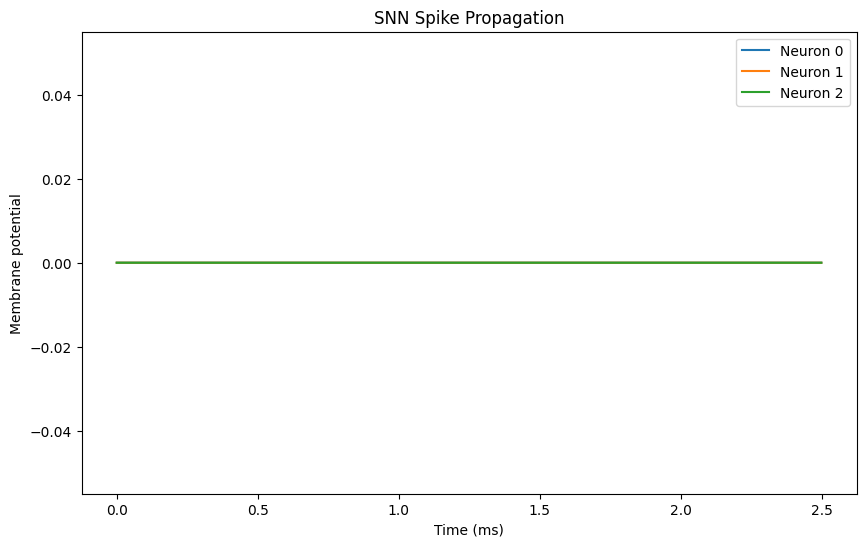

0
Neuron 0 spike times: []
1
Neuron 1 spike times: []
2
Neuron 2 spike times: []


In [6]:
input_spike_times = [(0, 0.1), (1, 0.9)]
snn = create_2_layer_SNN(input_spike_times)
run_current_SNN(snn)


In [7]:
from brian2 import *

defaultclock.dt = 0.0001*ms

@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1, sum=1, spikes_received=1)
def spike_timing(w, global_clock, layer, sum, spikes_received): 
    x = global_clock % 1
    return (x ** (1 - w)) if w >= 0 else (1 - (1 - x) ** (1 + w)) 

def create_snn(n_input=2, n_output=1):
    start_scope()

    stim = SpikeGeneratorGroup(n_input, indices=[], times=[]*ms)  # Placeholder

    n_total = n_input + n_output
    neurons = NeuronGroup(n_total, '''
        v : 1
        sum : 1
        spikes_received : 1
        scheduled_time : second
        global_clock : 1
    ''', threshold='v > 1', reset='v = 0', method='exact')

    neurons.v = 0
    neurons.scheduled_time = 1e9 * second
    neurons.global_clock = 0.0
    neurons.sum = 0.0
    neurons.spikes_received = 0.0

    syn_input = Synapses(stim, neurons[:n_input], '''
        w : 1
        layer : 1
    ''', on_pre='''
        spikes_received += 1
        sum += spike_timing(w, global_clock, layer, sum, spikes_received)
        scheduled_time = ((sum/spikes_received) + layer) * ms 
    ''')
    syn_input.connect(j='i')
    syn_input.w = 1.0
    syn_input.layer = 0

    syn_output = Synapses(neurons[:n_input], neurons[n_input:], '''
        w : 1
        layer : 1
    ''', on_pre='''
        spikes_received += 1
        sum += spike_timing(w, global_clock, layer, sum, spikes_received)
        scheduled_time = ((sum/spikes_received) + layer) * ms 
    ''')
    syn_output.connect()
    syn_output.w = 0.5
    syn_output.layer = 1

    neurons.run_regularly('''
        v = int(abs(t - scheduled_time) < 0.0005*ms) * 1.2
        global_clock += 0.001
    ''', dt=0.001*ms)

    monitors = {
        'v': StateMonitor(neurons, 'v', record=True, dt=0.001*ms),
        'spikes': SpikeMonitor(neurons),
        'stim_spikes': SpikeMonitor(stim),
    }

    return stim, neurons, syn_input, syn_output, monitors


In [8]:
def run_snn(stim, syn_output, monitors, input_spike_times, new_weights=None, runtime=3*ms):
    indices, times = zip(*input_spike_times)
    stim.set_spikes(indices, [t*ms for t in times])

    if new_weights is not None:
        syn_output.w = new_weights

    run(runtime)

    for i, spikes in monitors['spikes'].spike_trains().items():
        print(f"Neuron {i} spikes at: {[round(t/ms, 3) for t in spikes]} ms")

    # Optional plot
    figure()
    for i in range(len(monitors['v'].v)):
        plot(monitors['v'].t/ms, monitors['v'].v[i], label=f'Neuron {i}')
    xlabel('Time (ms)')
    ylabel('Membrane potential')
    legend()
    show()


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
INFO       Failed to vectorise code, falling back on Python loop: note that this will be very slow! Switch to another code generation target for best performance (e.g. cython). First line is: spikes_received += 1 (in-place) [brian2.codegen.generators.numpy_generator]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]


Neuron 0 spikes at: [] ms
Neuron 1 spikes at: [] ms
Neuron 2 spikes at: [] ms


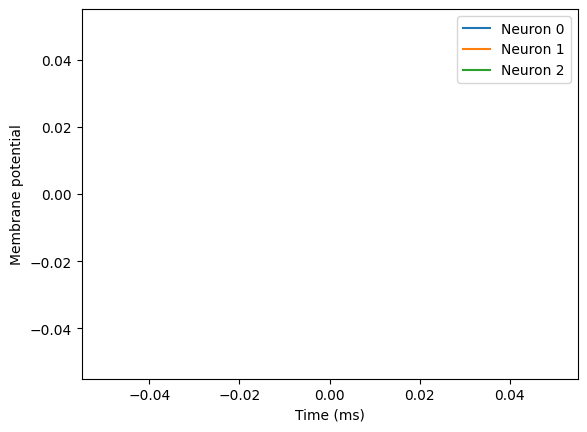

WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 5. ms), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]


Neuron 0 spikes at: [] ms
Neuron 1 spikes at: [] ms
Neuron 2 spikes at: [] ms


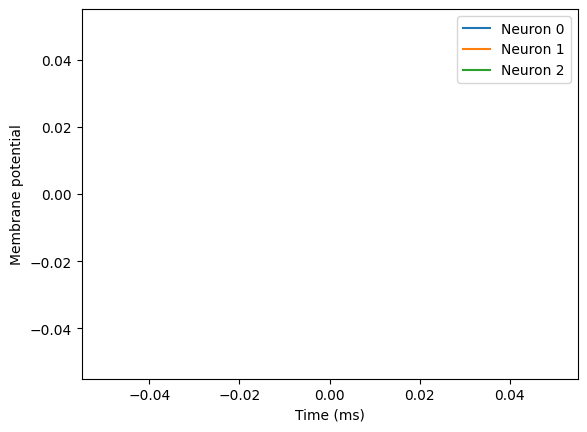

In [9]:
stim, neurons, syn_input, syn_output, monitors = create_snn()

# First run
run_snn(
    stim, syn_output, monitors,
    input_spike_times=[(0, 0.1), (1, 0.9)],
    new_weights=[0.6],  # try varying this
    runtime=5*ms
)

# Second run with new input
run_snn(
    stim, syn_output, monitors,
    input_spike_times=[(0, 0.2), (1, 0.3)],
    new_weights=[-0.4],
    runtime=5*ms
)
